## Cycling Potential
### How to calculate a trip cycling potential 

This notebook aims to define parameters to calculate a trip cycling potential, considering the current characteristics of São Paulo bike trips.

It is necessary to identify all attributes, calculate the attribute specific value and to develop a method to aggregate all attributes

In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}
od_routes_sp['length'] = od_routes_sp['geometry'].length * 100000
the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

total_trips = sum(od_routes_sp['FE_VIA'])
eps = 1e-5

# return a list [value_10, value_20, ..., value_100] 
# where value_x is the value whose x% of the data is less than it  
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - eps:
            stats.append(i[value])
    return stats

od_routes_FE_VIA = []
for i, r in od_routes_sp.iterrows():
    for w in range(round(r['FE_VIA'])):
        od_routes_FE_VIA.append(r)
        
od_routes_FE_VIA = pd.DataFrame(data = od_routes_FE_VIA, columns = od_routes_sp.columns)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Distance

The first attribute we consider is the trip distance.

The longer a trip is, the less cyclable it is. The distance is calculated using the routes calculated by the GraphHopper API. 

However, very short trips are hard to migrate to cycling because they are most likely made on foot.

The current Sao Paulo bike trips distance distribution is represented in the following graphs.

distance  10%:	 994
distance  20%:	 1343
distance  30%:	 1759
distance  40%:	 2310
distance  50%:	 2893
distance  60%:	 3703
distance  70%:	 4545
distance  80%:	 6613
distance  90%:	 10372
distance  100%:	 48888


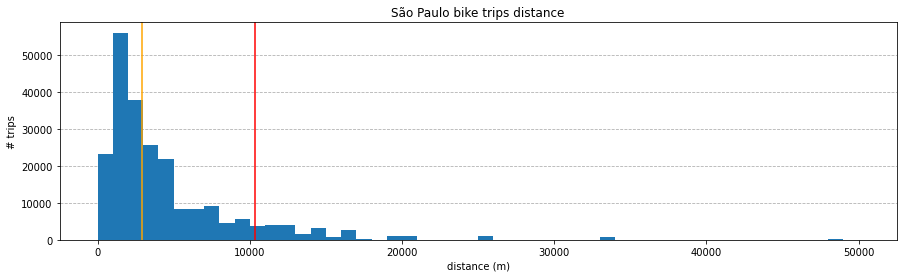

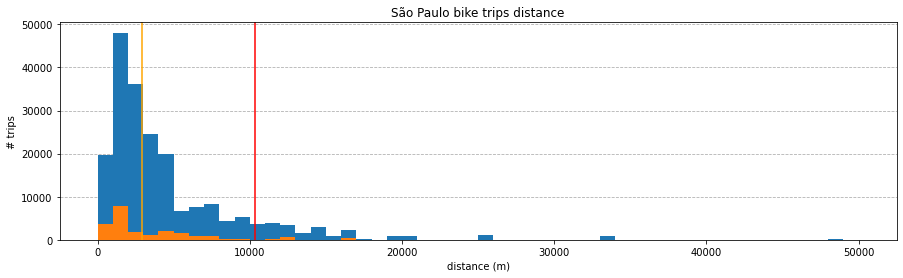

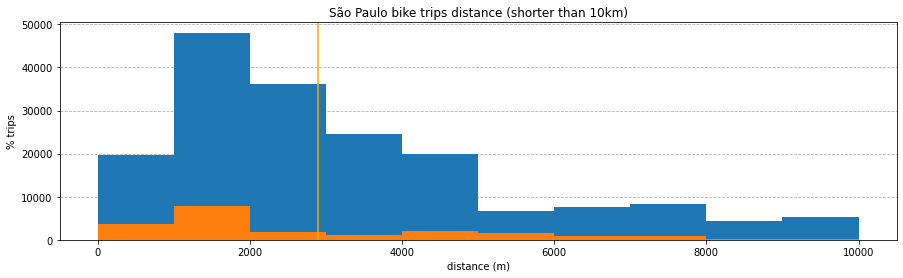

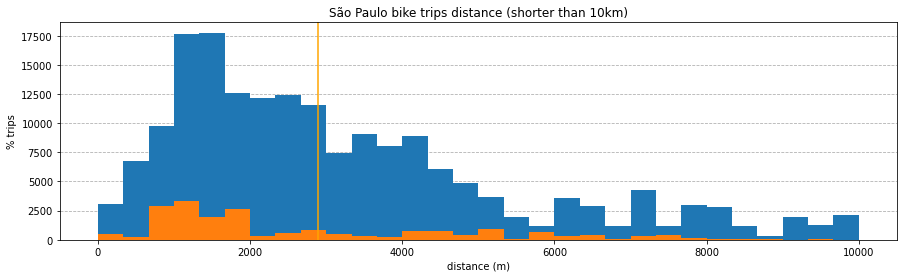

In [2]:
od_routes_sp = od_routes_sp.sort_values('length')

s = stats(od_routes_sp, 'length')
for i in range(10):
    print('distance  ' + str(i + 1) + '0%:\t', round(s[i]))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0, 50000))
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000))
plt.hist(bins=10,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000))
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000))
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000))
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

In [3]:
od_routes_sp['length_scaled'] = od_routes_sp['length'] / max(od_routes_sp['length'])
#distrib_scaled = dist.best_fit_distribution(od_routes_sp['length_scaled'], bins = 100)

#distrib = dist.best_fit_distribution(od_routes_sp['length'], bins = 100)

#distrib_m = dist.best_fit_distribution(od_routes_FE_VIA.loc[od_routes_FE_VIA['SEXO'] == 1]['length'], bins = 30)
#distrib_f = dist.best_fit_distribution(od_routes_FE_VIA.loc[od_routes_FE_VIA['SEXO'] == 2]['length'], bins = 30)

#('fisk', (1.846058042674543, 33.070799837068655, 2961.1647009341214))
#('johnsonsu', (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))
#display(distrib_m, distrib_f)

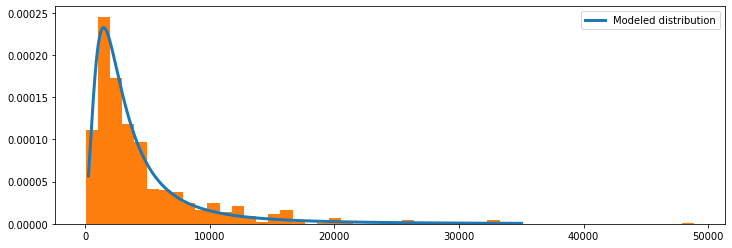

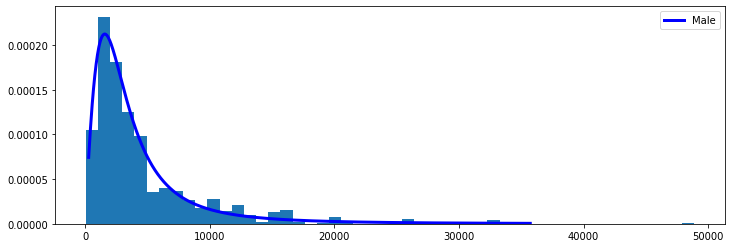

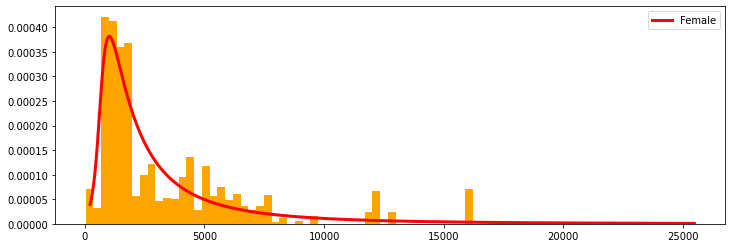

In [4]:
import scipy.stats as st

#display(distrib_weighted)
#'invweibull', (1.9570057637337088, -1328.576035175634, 3464.328480602161))

distance_pdf = dist.make_pdf(st.invweibull, (1.9570057637337088, -1328.576035175634, 3464.328480602161))
plt.figure(figsize=(12,4))
ax = distance_pdf.plot(lw=3, label='Modeled distribution', legend=True)
plt.hist(bins=50, x=od_routes_sp['length'], weights = od_routes_sp['FE_VIA'], density=True)
plt.show()

distance_pdf_m = dist.make_pdf(st.fisk, (1.846058042674543, 33.070799837068655, 2961.1647009341214))
plt.figure(figsize=(12,4))
ax = distance_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], density=True)
plt.show()

distance_pdf_f = dist.make_pdf(st.johnsonsu, (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))
plt.figure(figsize=(12,4))
ax = distance_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], density=True,color='orange')
plt.show()

# Slope

In [7]:
# calculating statistics
stats_slope = []
for _, r in od_routes_sp.iterrows():
    s = {}
    stretchs = split_route(r['geometry'], 'line', False)
    s['fe_via'] = r['FE_VIA']
    s['length'] = r['length']
    s['max'] = max([s[1] for s in stretchs])
    s['mean'] = sum([s[1]*s[0].length for s in stretchs])/r.length * 100000
    s['mean_pos'] = sum([max(0,s[1])*s[0].length for s in stretchs])/r.length * 100000
    stretchs = split_route(r['geometry'], 20, False)
    s['std_height'] = stdev([st[0].coords[0][2] for st in stretchs])
    s['sum_elevs'] = sum (max(0, st[0].coords[0][2] - st[0].coords[1][2]) for st in stretchs)
    for i in range(-150, 150):
        s['meters_slope_' + str(i)] = 0
        s['meters_slope_max_' + str(i)] = 0
    meters_in_slope = 0
    current_slope = round(stretchs[0][1])
    for st in stretchs:
        s['meters_slope_' + str(round(st[1]))] += st[0].length * 100000
        if current_slope == round(st[1]):
            meters_in_slope += st[0].length * 100000
        else:
            s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                              s['meters_slope_max_' + str(current_slope)])
            meters_in_slope = st[0].length * 100000
            current_slope = round(st[1])
    s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                      s['meters_slope_max_' + str(current_slope)])
        
    stats_slope.append(i[1] for i in s.items())  
    
c = ['fe_via', 'length', 'max', 'mean', 'mean_pos', 'std_height', 'sum_elevs']
for i in range(-150,150):
    c += ['meters_slope_' + str(i)] + ['meters_slope_max_' + str(i)]
df_stats = pd.DataFrame(data = stats_slope, columns = c)

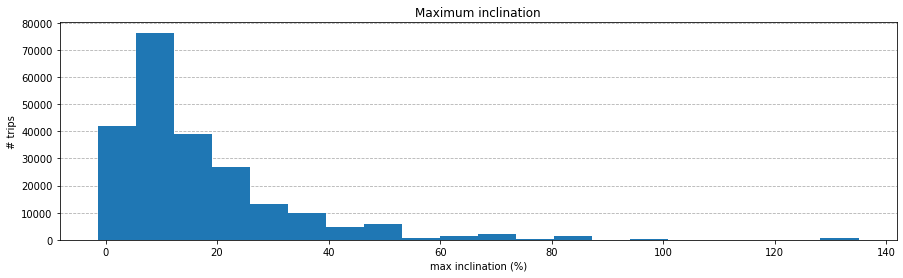

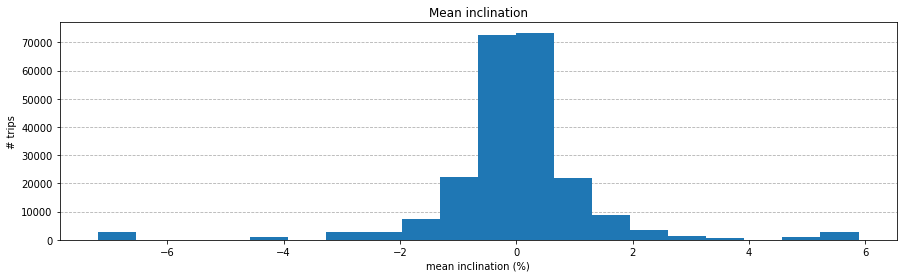

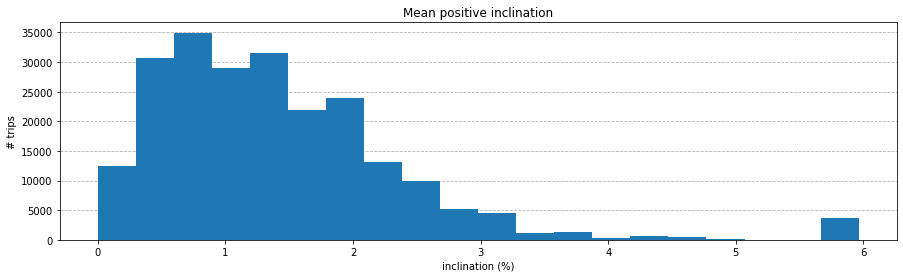

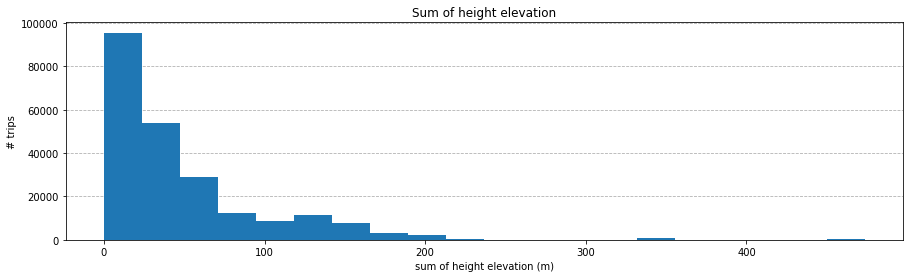

In [8]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['max'], weights = df_stats['fe_via'])
plt.title('Maximum inclination')
plt.xlabel('max inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean'], weights = df_stats['fe_via'])
plt.title('Mean inclination')
plt.xlabel('mean inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean_pos'], weights = df_stats['fe_via'])
plt.title('Mean positive inclination')
plt.xlabel('inclination (%)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['std_height'], weights = df_stats['fe_via'])
plt.title('Height Standard Deviation')
plt.xlabel('height standard deviation (m)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['sum_elevs'], weights = df_stats['fe_via'])
plt.title('Sum of height elevation')
plt.xlabel('sum of height elevation (m)')
plt.ylabel('# trips')
plt.show()

### Sum of distances in each level

In [9]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_down.append(meters_slope_i)

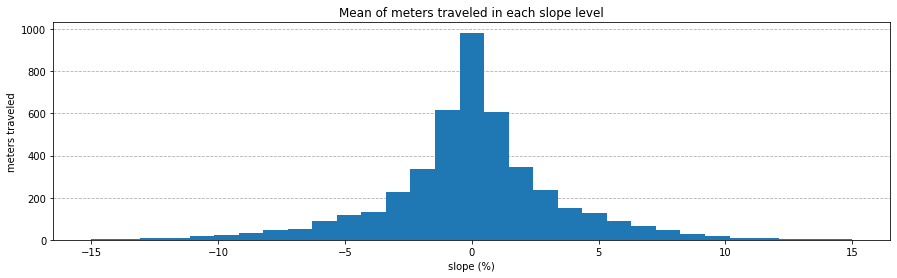

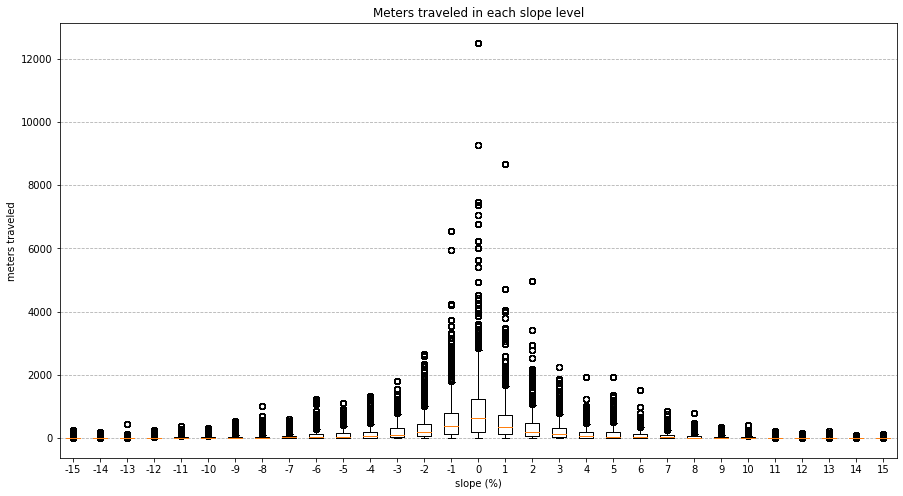

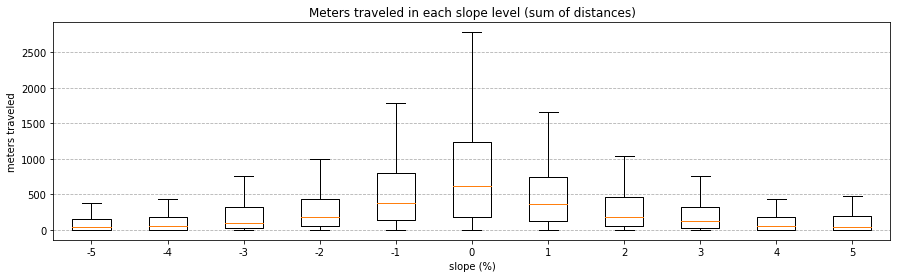

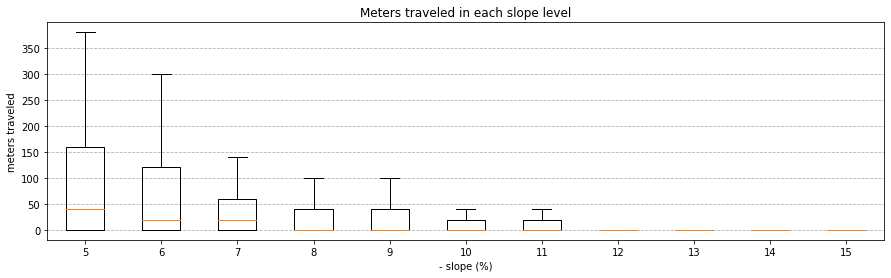

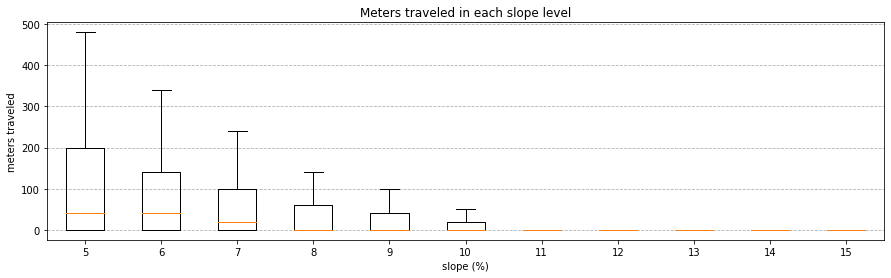

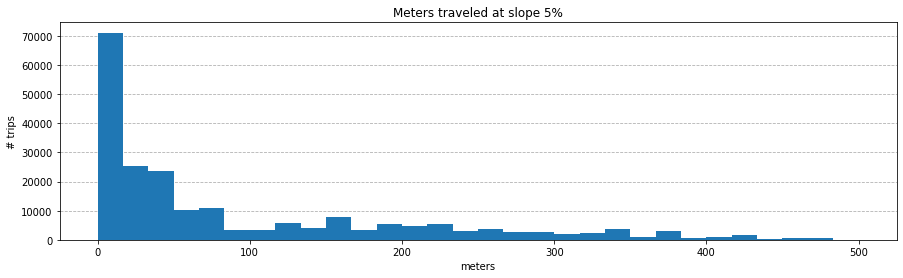

In [10]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (sum of distances)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

s = stats(df_stats, 'meters_slope_5', 'fe_via')

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30, x=df_stats['meters_slope_5'], weights=df_stats['fe_via'], range=(0, 500))
plt.title('Meters traveled at slope 5%')
plt.xlabel('meters')
plt.ylabel('# trips')
plt.show()

### Maximum distance in each level

In [11]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_max_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_down.append(meters_slope_i)

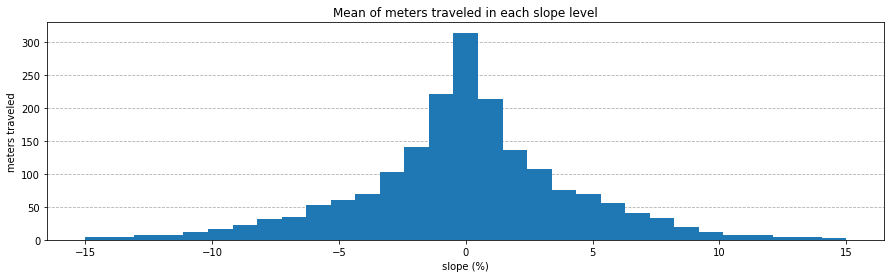

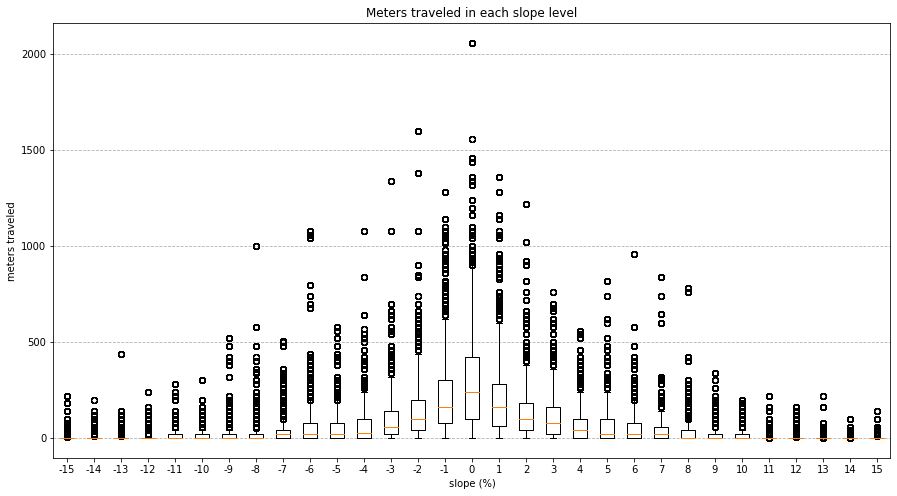

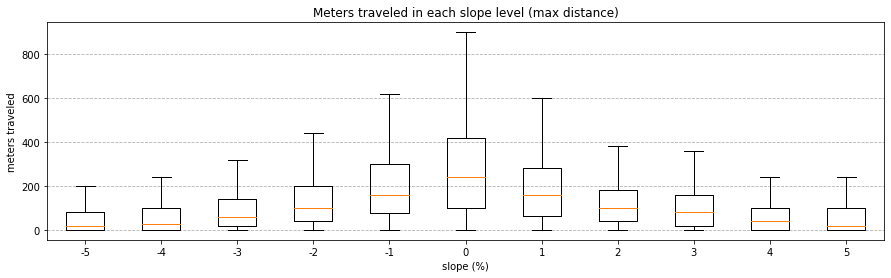

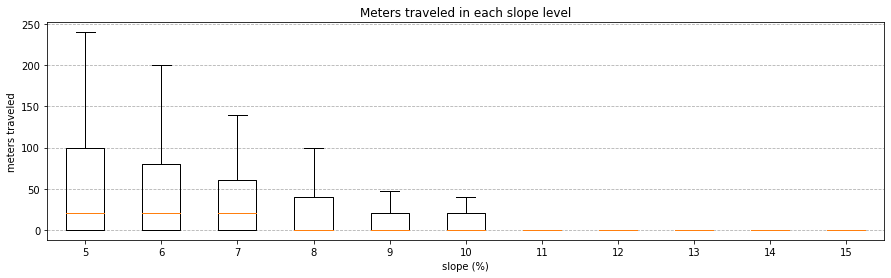

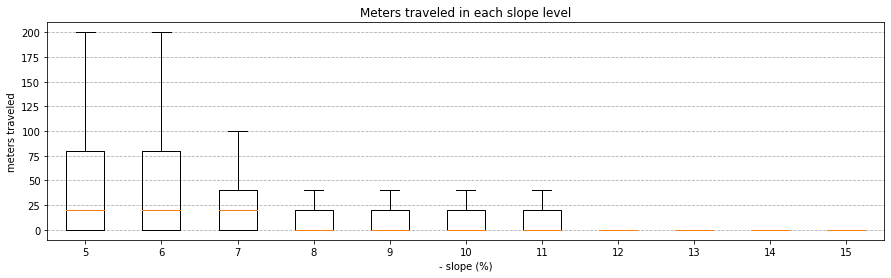

In [12]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (max distance)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

# Trip Reason

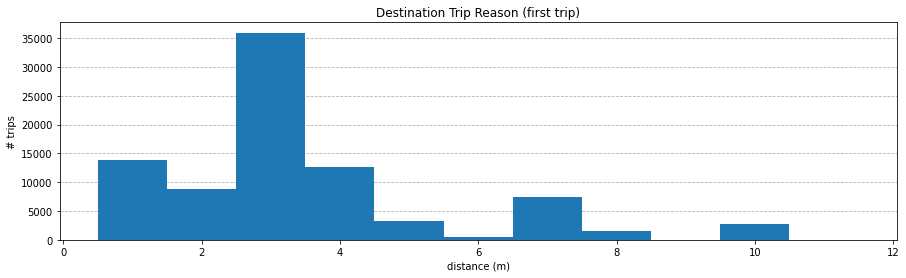

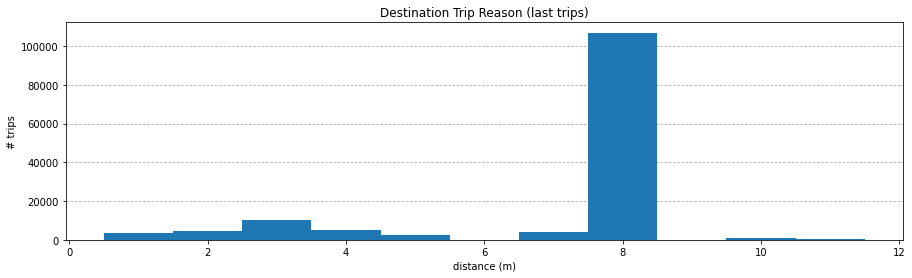

In [13]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_routes_sp['MOTIVO_D'].loc[od_routes_sp['N_VIAG'] == 1], weights = od_routes_sp['FE_VIA'].loc[od_routes_sp['N_VIAG'] == 1])
plt.title('Destination Trip Reason (first trip)')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_routes_sp['MOTIVO_D'].loc[od_routes_sp['N_VIAG'] > 1], weights = od_routes_sp['FE_VIA'].loc[od_routes_sp['N_VIAG'] > 1])
plt.title('Destination Trip Reason (last trips)')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.show()

# 1 - Trabalho Indústria
# 2 - Trabalho Comércio
# 3 - Trabalho Serviços
# 4 - Escola/Educação
# 5 - Compras1q
# 6 - Médico/Dentista/Saúde 
# 7 - Recreação/Visitas/Lazer
# 8 - Residência
# 9 - Procurar Emprego
# 10 - Assuntos Pessoais
# 11 - Refeição

# Week Day

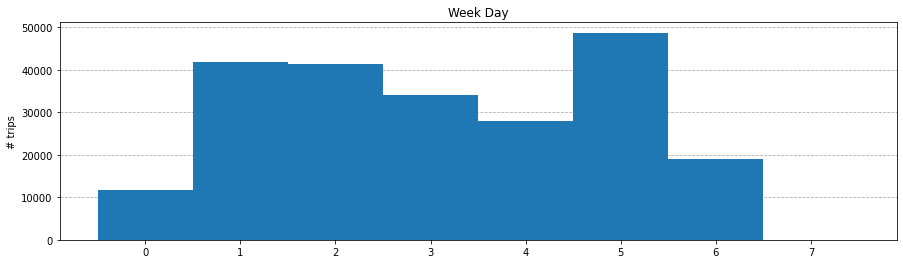

In [14]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(-1,8)], x=od_routes_sp['DIASEMANA'], weights = od_routes_sp['FE_VIA'])
plt.title('Week Day')
plt.ylabel('# trips')
plt.show()

# Day Period

10%:	 6.3
20%:	 7.3
30%:	 9.0
40%:	 12.0
50%:	 13.3
60%:	 15.3
70%:	 17.0
80%:	 18.0
90%:	 19.0
100%:	 23.3


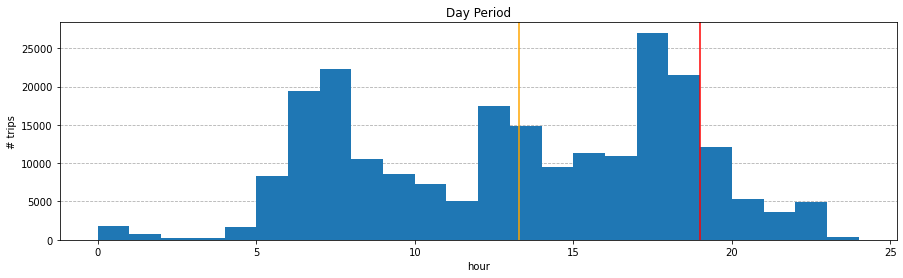

In [15]:
od_routes_sp['HORA_SAIDA_INT'] = [int(h[:2] + h[3:5]) / 100 for h in od_routes_sp['HORA_SAIDA']]
s = stats(od_routes_sp, 'HORA_SAIDA_INT')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i], 2))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(25), x=od_routes_sp['HORA_SAIDA_INT'], weights = od_routes_sp['FE_VIA'])
plt.title('Day Period')
plt.xlabel('hour')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

In [16]:
od_people = od_routes_sp.groupby('ID_PESS').max()


od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 100)
#distrib_m = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 1]['IDADE'], bins = 20)
#distrib_f = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 2]['IDADE'], bins = 5)
#print(distrib_m)
#print(distrib_f)
# bins=100
#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dgamma', (0.39638728719946925, 29.000000000000007, 9.770561148311165))

#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dweibull', (0.7423596624388107, 28.999999999999993, 8.493736966849728))

#('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))
#('gennorm', (0.3515821692724699, 29.0, 0.20540942031825238))

#('foldcauchy', (6.114613850953486, 0.9999999626040696, 4.4346970738639975))

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 25)
#print(distrib_weighted)
#genextreme', (0.195561684562034, 27.800891741589794, 13.381742809374167))

# Age

Age  10%:	 17
Age  20%:	 20
Age  30%:	 25
Age  40%:	 30
Age  50%:	 33
Age  60%:	 36
Age  70%:	 41
Age  80%:	 47
Age  90%:	 52
Age  100%:	 81


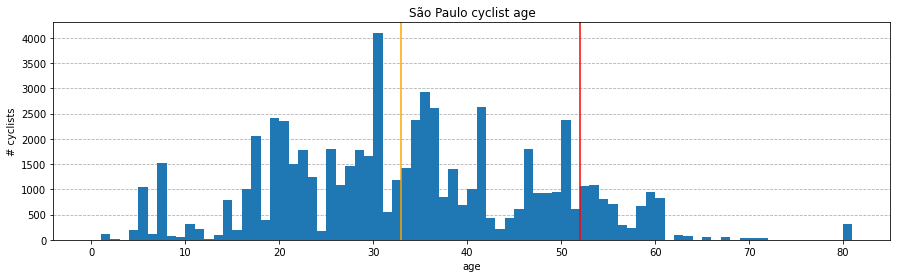

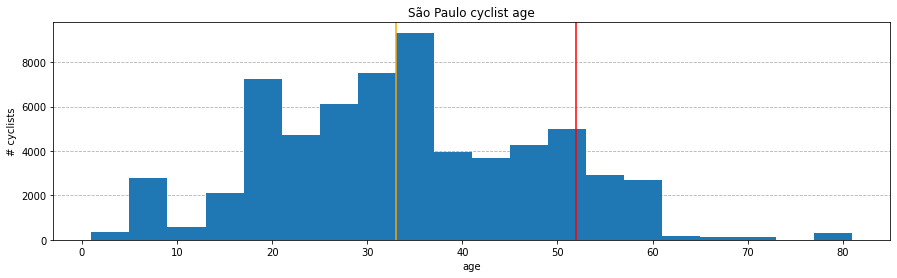

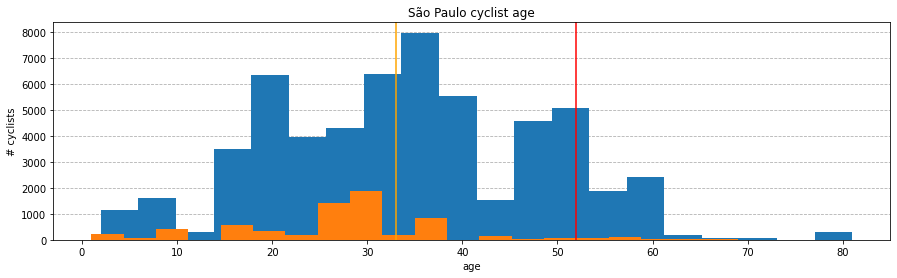

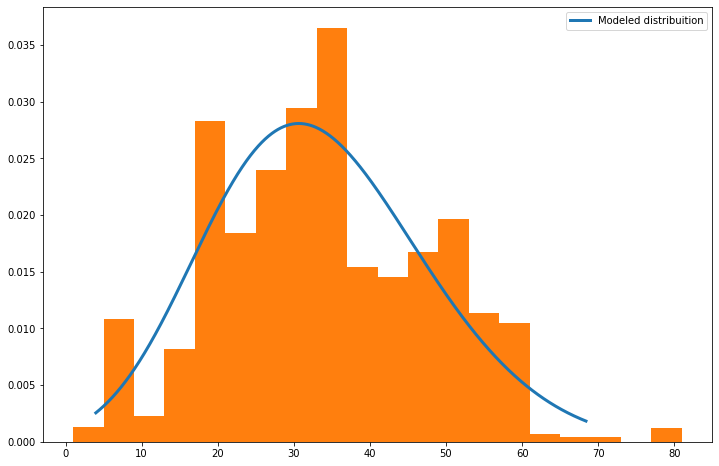

In [17]:
import scipy.stats as st
#display(distrib_weighted)
s = stats(od_people, 'IDADE', 'FE_PESS')
for i in range(10):
    print('Age  ' + str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(82), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'])
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

distance_pdf = dist.make_pdf(st.genextreme, (0.195561684562034, 27.800891741589794, 13.381742809374167))
plt.figure(figsize=(12,8))
ax = distance_pdf.plot(lw=3, label='Modeled distribuition', legend=True)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'], density=True)
plt.show()

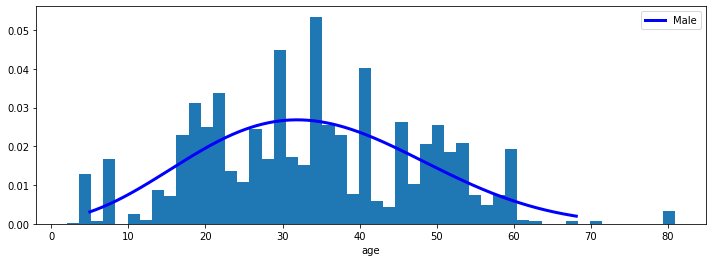

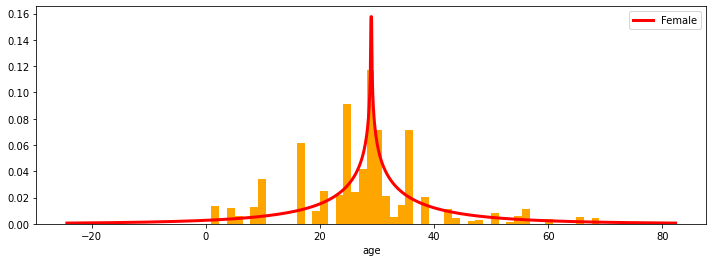

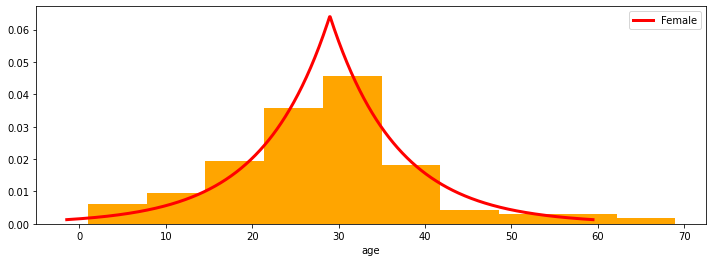

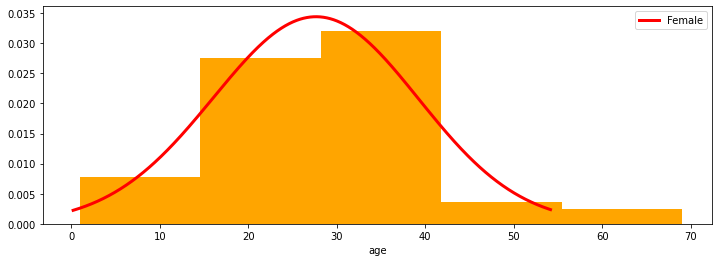

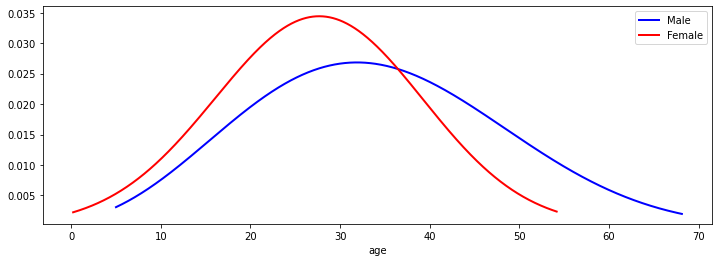

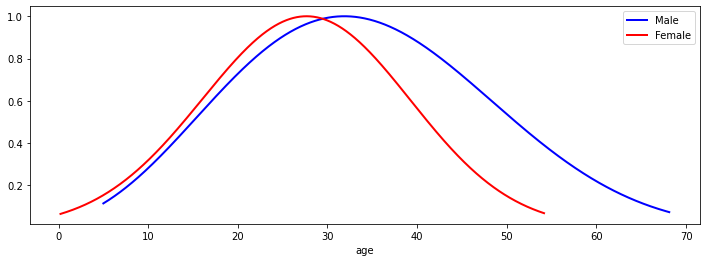

In [18]:
#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dgamma', (0.39638728719946925, 29.000000000000007, 9.770561148311165)) fem 100 bins
#('dweibull', (0.7423596624388107, 28.999999999999993, 8.493736966849728)) fem 50 bins

# 20 bins
#('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))
#('gennorm', (0.3515821692724699, 29.0, 0.20540942031825238))
#('foldcauchy', (6.114613850953486, 0.9999999626040696, 4.4346970738639975))
#('laplace', (29.0, 7.783973688144715))
#('loggamma', (897.3569843061273, -2332.923603808461, 347.1732584129129))


age_pdf_m = dist.make_pdf(st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
age_pdf_f = dist.make_pdf(st.dweibull, (0.7423596624388107, 28.999999999999993, 8.493736966849728))
plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'], density=True)
ax = age_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.laplace, (29.0, 7.783973688144715))
plt.figure(figsize=(12,4))
plt.hist(bins = 10, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.loggamma, (897.3569843061273, -2332.923603808461, 347.1732584129129))
plt.figure(figsize=(12,4))
plt.hist(bins = 5, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
ax = age_pdf_m.plot(lw=2, label='Male', legend=True, color='blue')
ax = age_pdf_f.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

max_m = max(d for d in age_pdf_m)
max_f = max(d for d in age_pdf_f)
age_m_scaled = age_pdf_m / max_m
age_f_scaled = age_pdf_f / max_f

plt.figure(figsize=(12,4))
ax = age_m_scaled.plot(lw=2, label='Male', legend=True, color='blue')
ax = age_f_scaled.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()


# Car Ownership

Cars quantity  10%:	 0.0
Cars quantity  20%:	 0.0
Cars quantity  30%:	 0.0
Cars quantity  40%:	 0.0
Cars quantity  50%:	 0.2
Cars quantity  60%:	 0.25
Cars quantity  70%:	 0.33
Cars quantity  80%:	 0.4
Cars quantity  90%:	 0.5
Cars quantity  100%:	 2.0


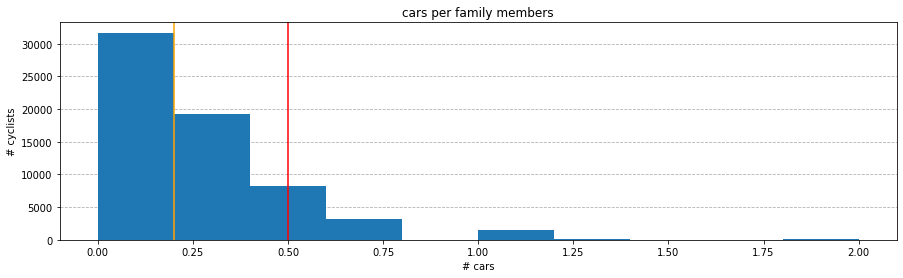

In [19]:
od_people['CARS_PER_FAMILY'] = od_people['QT_AUTO'] / od_people['NO_MORAF']
s = stats(od_people, 'CARS_PER_FAMILY', 'FE_PESS')
for i in range(10):
    print('Cars quantity  ' + str(i + 1) + '0%:\t', round(s[i], 2))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10, x=od_people['CARS_PER_FAMILY'], weights = od_people['FE_PESS'])
plt.title('cars per family members')
plt.xlabel('# cars')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

# Economic Classification

10%:	 1
20%:	 2
30%:	 3
40%:	 3
50%:	 4
60%:	 4
70%:	 4
80%:	 5
90%:	 6
100%:	 6


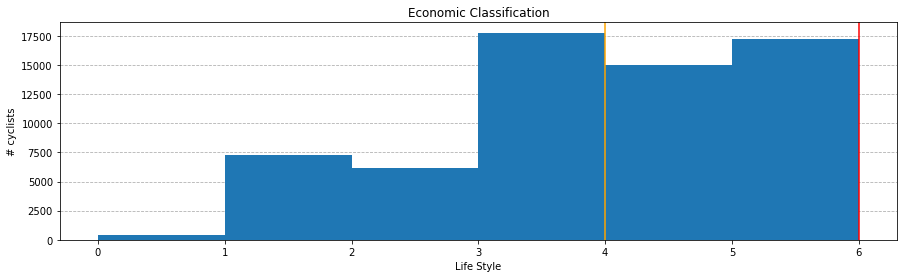

In [20]:
s = stats(od_people, 'CRITERIOBR', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(7), x=od_people['CRITERIOBR'], weights = od_people['FE_PESS'])
plt.title('Economic Classification')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

# 1 - A
# 2 - B1
# 3 - B2
# 4 - C1
# 5 - C2
# 6 - D - E


10%:	 0
20%:	 0
30%:	 0
40%:	 0
50%:	 0
60%:	 1200
70%:	 1500
80%:	 2000
90%:	 3200
100%:	 20000


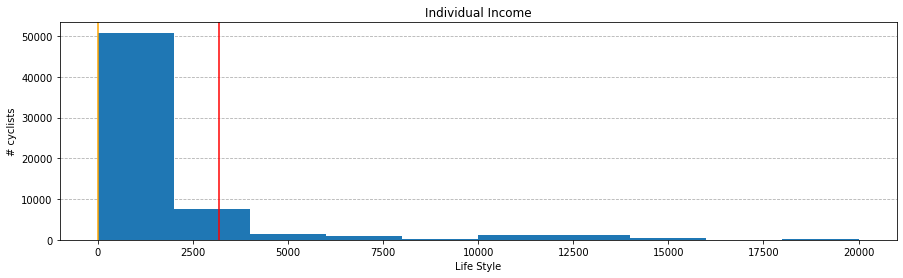

10%:	 425
20%:	 550
30%:	 683
40%:	 900
50%:	 1130
60%:	 1350
70%:	 1793
80%:	 2345
90%:	 3709
100%:	 20000


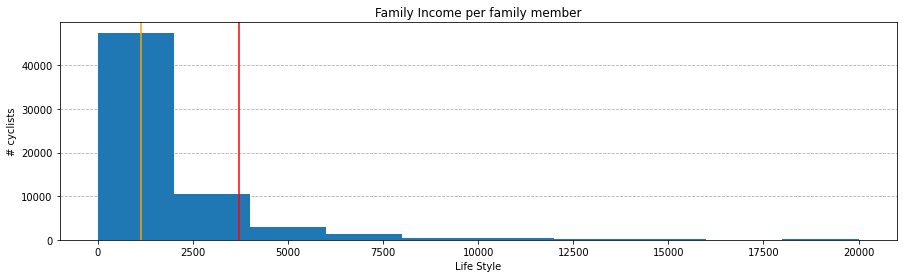

10%:	 1
20%:	 1
30%:	 1
40%:	 1
50%:	 1
60%:	 2
70%:	 3
80%:	 3
90%:	 3
100%:	 6


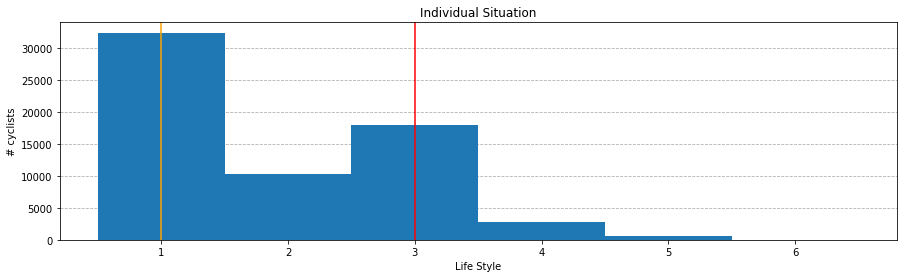

In [21]:
s = stats(od_people, 'VL_REN_I', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(x=od_people['VL_REN_I'], weights = od_people['FE_PESS'])
plt.title('Individual Income')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

od_people['mean_income'] = od_people['RENDA_FA'] / od_people['NO_MORAF']
s = stats(od_people, 'mean_income', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(x=od_people['mean_income'], weights = od_people['FE_PESS'])
plt.title('Family Income per family member')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

s = stats(od_people, 'SIT_FAM', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['SIT_FAM'], weights = od_people['FE_PESS'])
plt.title('Individual Situation')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

# 1 - Pessoa Responsável
# 2 - Cônjuge/Companheiro(a)
# 3 - Filho(a)/Enteado(a)
# 4 - Outro Parente
# 5 - Agregado
# 6 - Empregado Residente
# 7 - Parente do Empregado Residente

# Education

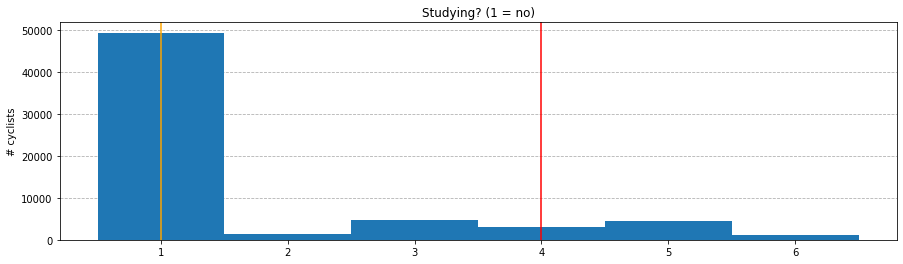

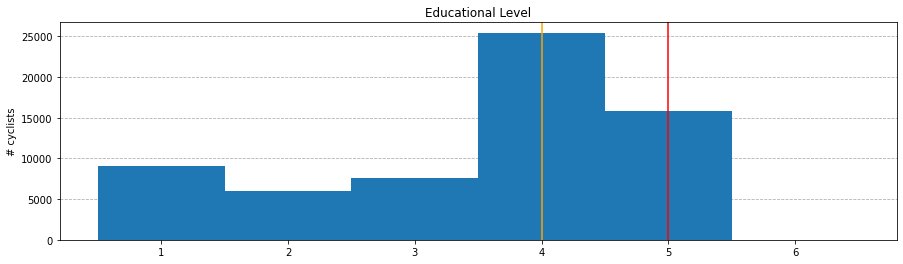

In [22]:
s = stats(od_people, 'ESTUDA', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['ESTUDA'], weights = od_people['FE_PESS'])
plt.title('Studying? (1 = no)')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

s = stats(od_people, 'GRAU_INS', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['GRAU_INS'], weights = od_people['FE_PESS'])
plt.title('Educational Level')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

#1 - Não-Alfabetizado/Fundamental I Incompleto
#2 - Fundamental I Completo/Fundamental II Incompleto
#3 - Fundamental II Completo/Médio Incompleto
#4 - Médio Completo/Superior Incompleto
#5 - Superior Completog


# Number of trips

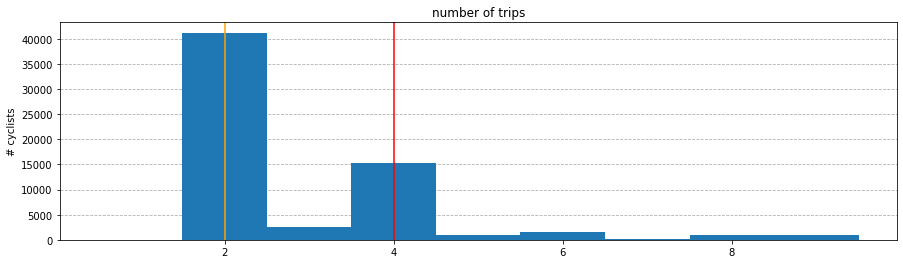

In [23]:
s = stats(od_people, 'TOT_VIAG', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(10)], x=od_people['TOT_VIAG'], weights = od_people['FE_PESS'])
plt.title('number of trips')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   